In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import warnings

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO)

# Problem Definition

## Silent Model Degradation

Machine learning models often degrade silently in production due to **data drift** - when the distribution of incoming data changes from what the model was trained on.

The challenge? **Ground truth labels are often delayed.** In many real-world applications:
- Loan default labels arrive months after predictions
- Fraud labels require investigation that takes weeks
- Customer churn is only known after the fact

Traditional accuracy monitoring can't help until labels arrive. By then, the model may have made thousands of poor predictions.

## SHAP-Based Monitoring

**SHAP monitoring can detect shifts earlier** by tracking how feature contributions change over time. When the input distribution shifts, the model's internal decision-making process changes - and SHAP values capture this, no labels required.

## This Example: Simulating Age-Based Covariate Shift

We'll simulate a realistic drift scenario using the UCI Adult Income dataset:

1. **Training Phase**: Build a model on younger individuals
2. **Day 1 - Deployment**: Monitor SHAP values on validation data (similar to training)
3. **Day 2 - Drift Occurs**: Production data shifts to older individuals

This simulates what happens when a model trained on one demographic is deployed to serve a different population.

# Load the UCI Adult Dataset

In [5]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X: pd.DataFrame = adult.data.features
y: pd.DataFrame = adult.data.targets

print(X.shape, y.shape)

(48842, 14) (48842, 1)


In [6]:
X.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [7]:
y.value_counts()

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

In [8]:
y["income"] = y["income"].map({"<=50K": 0, "<=50K.": 0, ">50K": 1, ">50K.": 1})
y.value_counts()

income
0         37155
1         11687
Name: count, dtype: int64

In [9]:
X["age"].describe()

count    48842.000000
mean        38.643585
std         13.710510
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

# Create Data Splits

Here's where we set up the drift scenario. Instead of a random split, we create a **deliberate distribution shift**:

- **Training data**: Individuals age ≤ 45 (younger population)
- **"Production" data**: Individuals age > 45 (older population)

This simulates a model that was developed using data from younger users, then deployed to serve an aging customer base.

In [31]:
# Convert categorical columns before splitting so train/test share the same categories
for col in X.select_dtypes(include=["object", "string"]).columns:
    X[col] = X[col].astype("category")

X_train = X[X["age"] <= 45].copy()
X_test = X[X["age"] > 45].copy()
y_train = y.loc[X_train.index].copy()
y_test = y.loc[X_test.index].copy()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34298, 14) (14544, 14) (34298, 1) (14544, 1)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(24008, 14) (10290, 14) (24008, 1) (10290, 1)


## Visualizing the Distribution Shift

Let's examine how the data distributions differ between our training population and the "drifted" production data:

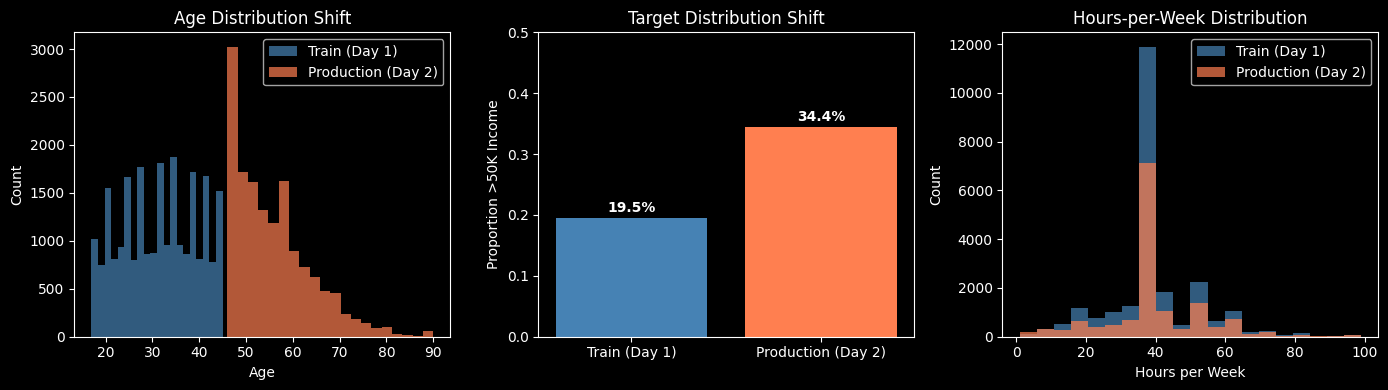

Train set: 24,008 samples, 19.5% high income
Production set: 14,544 samples, 34.4% high income


In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Age distribution
axes[0].hist(X_train["age"], bins=20, alpha=0.7, label="Train (Day 1)", color="steelblue")
axes[0].hist(X_test["age"], bins=20, alpha=0.7, label="Production (Day 2)", color="coral")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")
axes[0].set_title("Age Distribution Shift")
axes[0].legend()

# Income distribution (target)
train_income_rate = y_train["income"].mean()
test_income_rate = y_test["income"].mean()
axes[1].bar(
    ["Train (Day 1)", "Production (Day 2)"],
    [train_income_rate, test_income_rate],
    color=["steelblue", "coral"],
)
axes[1].set_ylabel("Proportion >50K Income")
axes[1].set_title("Target Distribution Shift")
axes[1].set_ylim(0, 0.5)
for i, v in enumerate([train_income_rate, test_income_rate]):
    axes[1].text(i, v + 0.01, f"{v:.1%}", ha="center", fontweight="bold")

# Hours per week distribution
axes[2].hist(
    X_train["hours-per-week"], bins=20, alpha=0.7, label="Train (Day 1)", color="steelblue"
)
axes[2].hist(
    X_test["hours-per-week"], bins=20, alpha=0.7, label="Production (Day 2)", color="coral"
)
axes[2].set_xlabel("Hours per Week")
axes[2].set_ylabel("Count")
axes[2].set_title("Hours-per-Week Distribution")
axes[2].legend()

plt.tight_layout()

print(f"Train set: {len(X_train):,} samples, {train_income_rate:.1%} high income")
print(f"Production set: {len(X_test):,} samples, {test_income_rate:.1%} high income")

# Train the Model

We train a LightGBM classifier on the younger population. This represents the model development phase before deployment.

## Set Categorical Columns

In [34]:
categorical_cols = X_train.select_dtypes(include=["category"]).columns.tolist()
print(categorical_cols)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


## LightGBM Model

In [35]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train["income"], categorical_feature=categorical_cols)

[LightGBM] [Info] Number of positive: 4675, number of negative: 19333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 611
[LightGBM] [Info] Number of data points in the train set: 24008, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194727 -> initscore=-1.419584
[LightGBM] [Info] Start training from score -1.419584


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Evaluate Model Performance

In a real production scenario, we wouldn't have ground truth labels immediately - they might arrive days or weeks later. Here we show the accuracy comparison **retrospectively** to demonstrate that drift did cause performance degradation.

The challenge: **How do we detect this problem before labels are available?**

### Day 1: Validation Performance (Known at Deployment)

In [36]:
from sklearn.metrics import classification_report, f1_score

y_pred_val = model.predict(X_val)
print(classification_report(y_val["income"], y_pred_val))

print(f"F1 Score (Day 1 - Validation): {f1_score(y_val['income'], y_pred_val):.4f}")

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      8286
           1       0.77      0.66      0.71      2004

    accuracy                           0.90     10290
   macro avg       0.85      0.80      0.82     10290
weighted avg       0.89      0.90      0.89     10290

F1 Score (Day 1 - Validation): 0.7097


### Day 2: Production Performance (Unknown Until Labels Arrive)

Note that the F1 score is very similar to Day 1, even though the data distribution has shifted significantly. Traditional accuracy metrics may not reveal the problem immediately.

In [37]:
y_pred_test = model.predict(X_test)
print(classification_report(y_test["income"], y_pred_test))

print(f"F1 Score (Day 2 - Production): {f1_score(y_test['income'], y_pred_test):.4f}")

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      9536
           1       0.77      0.68      0.72      5008

    accuracy                           0.82     14544
   macro avg       0.81      0.79      0.79     14544
weighted avg       0.82      0.82      0.82     14544

F1 Score (Day 2 - Production): 0.7213


# SHAP Monitoring

## Log Day 1 (Baseline)

In [38]:
from shap import TreeExplainer
from shapmonitor import SHAPMonitor


monitor = SHAPMonitor(explainer=TreeExplainer(model), data_dir=".shap_example", sample_rate=1.0)
monitor.log_batch(X_val, y_val["income"])

INFO:shapmonitor.backends._parquet:ParquetBackend initialized at: .shap_example
INFO:shapmonitor.backends._parquet:Wrote batch d2510a60-c28a-4e13-8a1b-bef0f76b9e23 to .shap_example/2026-01-03/d2510a60-c28a-4e13-8a1b-bef0f76b9e23.parquet
INFO:shapmonitor.monitor:Logged SHAP explanations for batch_id: d2510a60-c28a-4e13-8a1b-bef0f76b9e23 in path: .shap_example/2026-01-03/d2510a60-c28a-4e13-8a1b-bef0f76b9e23.parquet


## Analyze Day 1

This shows the typical SHAP distribution when the model sees data similar to training:

In [39]:
from shapmonitor.analysis import SHAPAnalyzer
from shapmonitor.backends import ParquetBackend
from datetime import datetime


backend = ParquetBackend(".shap_example")

analyzer = SHAPAnalyzer(backend)
analyzer.summary(start_dt=datetime(2026, 1, 3), end_dt=datetime(2026, 1, 4))

INFO:shapmonitor.backends._parquet:ParquetBackend initialized at: .shap_example


,mean_abs,mean,std,min,max
feature,,,,,
marital-status,0.925870,0.283519,0.981052,-1.741652,2.672566
age,0.879709,0.469869,0.866594,-3.890297,1.888425
capital-gain,0.600387,0.105647,1.610889,-2.730889,10.082270
relationship,0.507157,0.151912,0.554702,-1.255027,1.794199
education-num,0.404461,-0.009525,0.506495,-1.441561,1.943707
occupation,0.403324,0.000005,0.477566,-1.122057,1.323431
hours-per-week,0.392157,-0.041315,0.575515,-2.496268,2.059775
capital-loss,0.129010,-0.001274,0.451875,-2.567315,5.098184
fnlwgt,0.109149,-0.001729,0.159564,-0.681679,2.446137


## Log Day 2

Now we simulate the next day when drifted data starts arriving:

In [40]:
import freezegun

with freezegun.freeze_time("2026-01-04"):
    monitor.log_batch(X_test, y_test["income"])

INFO:shapmonitor.backends._parquet:Wrote batch 5766899a-fa16-4ba4-b343-971427457e11 to .shap_example/2026-01-04/5766899a-fa16-4ba4-b343-971427457e11.parquet
INFO:shapmonitor.monitor:Logged SHAP explanations for batch_id: 5766899a-fa16-4ba4-b343-971427457e11 in path: .shap_example/2026-01-04/5766899a-fa16-4ba4-b343-971427457e11.parquet


## Analyze Day 2

Notice the changes in SHAP value distributions compared to Day 1:

In [41]:
analyzer.summary(start_dt=datetime(2026, 1, 4), end_dt=datetime(2026, 1, 5))

,mean_abs,mean,std,min,max
feature,,,,,
age,1.008657,1.008642,0.208327,-0.120416,1.888425
marital-status,0.885850,0.555139,0.828213,-1.618961,2.543012
capital-gain,0.758410,0.234278,1.900416,-2.730889,9.942020
relationship,0.532142,0.306785,0.512468,-1.247210,1.575416
education-num,0.450890,-0.030426,0.548470,-1.441561,1.943707
occupation,0.437279,0.006289,0.508474,-1.122057,1.323431
hours-per-week,0.403428,-0.077964,0.607200,-2.496268,1.967175
capital-loss,0.158041,0.010045,0.519835,-2.567315,5.098184
fnlwgt,0.110938,-0.005252,0.152969,-0.681679,1.438243


## SHAP Comparison

The `compare_time_periods` method reveals how the model's decision-making process has changed:

In [43]:
analyzer.compare_time_periods(
    start_1=datetime(2026, 1, 3),
    end_1=datetime(2026, 1, 4),
    start_2=datetime(2026, 1, 4),
    end_2=datetime(2026, 1, 5),
)

,mean_abs_1,mean_abs_2,delta_mean_abs,pct_delta_mean_abs,mean_1,mean_2,rank_1,rank_2,delta_rank,rank_change,sign_flip
feature,,,,,,,,,,,
age,0.915893,1.008657,0.092764,10.128264,0.574991,1.008642,1.0,1.0,0.0,no_change,False
marital-status,0.898937,0.885850,-0.013088,-1.455887,0.308567,0.555139,2.0,2.0,0.0,no_change,False
capital-gain,0.632074,0.758410,0.126337,19.987635,0.126383,0.234278,3.0,3.0,0.0,no_change,False
relationship,0.523694,0.532142,0.008448,1.613145,0.179350,0.306785,4.0,4.0,0.0,no_change,False
education-num,0.409120,0.450890,0.041770,10.209848,-0.014407,-0.030426,5.0,5.0,0.0,no_change,False
occupation,0.408705,0.437279,0.028574,6.991309,0.003173,0.006289,6.0,6.0,0.0,no_change,False
hours-per-week,0.389636,0.403428,0.013792,3.539739,-0.044279,-0.077964,7.0,7.0,0.0,no_change,False
capital-loss,0.136315,0.158041,0.021726,15.937980,-0.000427,0.010045,8.0,8.0,0.0,no_change,True
fnlwgt,0.109380,0.110938,0.001557,1.423934,-0.002047,-0.005252,9.0,9.0,0.0,no_change,False


# Interpreting the Comparison Signals

At this point in production, we have no accuracy metrics for Day 2 - labels haven't arrived. Yet SHAP monitoring has revealed drift:

### Feature Importance Shifts (mean_abs)

| Feature | Change | Interpretation |
|---------|--------|----------------|
| `age` | +10% | Model relies more heavily on age as the population shifts older |
| `capital-gain` | +20% | Older individuals have more capital gains, increasing this feature's influence |
| `workclass` | +22% | Employment patterns differ between age groups |

### Mean SHAP Direction

The `mean` column shows how feature contributions shift directionally:
- `age`: 0.57 → 1.01 (nearly doubled) - strongly pushing predictions positive for older population
- `marital-status`: 0.31 → 0.56 - increased positive contribution
- `relationship`: 0.18 → 0.31 - increased positive contribution

### Sign Flips

Features where the direction of influence reversed:
- `capital-loss`: Mean contribution flipped from -0.0004 to +0.01
- `workclass`: Mean contribution flipped from +0.0002 to -0.002

Sign flips indicate relationships learned during training may not hold for the new population.

### Key Observation

Traditional metrics (F1: 0.71 → 0.72) suggest the model is performing similarly. SHAP monitoring reveals the model's internal reasoning has changed substantially - a signal that warrants investigation before labels confirm any issues.

# Summary

This example demonstrated SHAP-based drift detection using `shapmonitor`:

1. **Log SHAP values** during normal operation to establish baseline patterns
2. **Compare time periods** to identify shifts in feature importance and contribution direction
3. **Detect drift signals** (importance changes, sign flips) before accuracy metrics are available

SHAP monitoring provides visibility into model reasoning changes, enabling investigation before delayed labels confirm performance issues.